# Predicting Dengue Spread

## Project Overview

In this notebook we examine feature imacting the occuance of Dengue Fever and employ several machine learning model to predict its spread. Dengue surveillance data is provided by the U.S. Centers for Disease Control and prevention, as well as the Department of Defense's Naval Medical Research Unit 6 and the Armed Forces Health Surveillance Center, in collaboration with the Peruvian government and U.S. universities. Environmental and climate data is provided by the National Oceanic and Atmospheric Administration (NOAA), an agency of the U.S. Department of Commerce.
The project is part of the "Predict the Next Pandemic Initiative"

The data set is hosted at Driven Data, which provides datasets that explore social and humanitarian issues. They also host machine learning competions, similar to Kaggle, but the overarching goal of all competitions is to provides some sort of humaniarial benefit. It's machine learning with a heart!

Here is a link to Driven Data: https://www.drivendata.org/ 
More information on the Dengue issue can be found here: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/81/

If you are unfamiliar with Dengue Fever (it is uncommon in the US), is a mosquito-borne tropical disease common in more than 110 countries, mainly in Asia and South America. Each year between 50 and 528 million people are infected and approximately 10,000 to 20,000 die.
The Wikipedia page is a good resouce: https://en.wikipedia.org/wiki/Dengue_fever

### Here are the starting features

City and date indicators
* city – City abbreviations: sj for San Juan and iq for Iquitos
* week_start_date – Date given in yyyy-mm-dd format

NOAA's GHCN daily climate data weather station measurements
* station_max_temp_c – Maximum temperature
* station_min_temp_c – Minimum temperature
* station_avg_temp_c – Average temperature
* station_precip_mm – Total precipitation
* station_diur_temp_rng_c – Diurnal temperature range

PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
* precipitation_amt_mm – Total precipitation

NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
* reanalysis_sat_precip_amt_mm – Total precipitation
* reanalysis_dew_point_temp_k – Mean dew point temperature
* reanalysis_air_temp_k – Mean air temperature
* reanalysis_relative_humidity_percent – Mean relative humidity
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity
* reanalysis_precip_amt_kg_per_m2 – Total precipitation
* reanalysis_max_air_temp_k – Maximum air temperature
* reanalysis_min_air_temp_k – Minimum air temperature
* reanalysis_avg_temp_k – Average air temperature
* reanalysis_tdtr_k – Diurnal temperature range

Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
* ndvi_se – Pixel southeast of city centroid
* ndvi_sw – Pixel southwest of city centroid
* ndvi_ne – Pixel northeast of city centroid
* ndvi_nw – Pixel northwest of city centroid

### Target Variable

The target we are investigating is "totol cases", which is a specifies for each city, year, and weekofyear. 

#### Lets begin:

In [249]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [250]:
data_path = []
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data_path.append(os.path.join(dirname, filename))
        


.\dengue_analyze.py
.\dengue_features_train.csv
.\dengue_labels_train.csv
.\dengue_predict.ipynb
.\Untitled.ipynb
.\Wells-Gray_Res_DA_10172019.docx
.\.ipynb_checkpoints\dengue_predict-checkpoint.ipynb
.\.ipynb_checkpoints\Untitled-checkpoint.ipynb


In [251]:
# Load the data
df_feat = pd.read_csv(data_path[1])
df_targ = pd.read_csv(data_path[2])
#print(df_targ.columns)

## Data Exploration

In [252]:
# df_o will be our original dataframe, which will be left untouched
df_o=pd.concat([df_feat,df_targ.total_cases],axis=1)
df_o.sample(5)
#df_o.columns

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
294,sj,1995,51,1995-12-24,NaN,0.035967,0.180857,0.111657,0.00,298.194286,...,77.637143,0.00,15.371429,1.700000,25.714286,5.857143,30.0,22.2,53.9,17
418,sj,1998,20,1998-05-14,NaN,0.042550,0.131783,0.100300,55.76,299.200000,...,78.401429,55.76,16.502857,3.628571,27.142857,7.014286,33.9,22.2,7.1,46
1004,iq,2001,43,2001-10-22,0.124483,0.239267,0.184500,0.205571,77.15,298.584286,...,90.265714,77.15,18.267143,9.857143,28.066667,11.966667,35.0,21.0,89.1,0
911,sj,2007,45,2007-11-05,-0.251700,-0.048600,0.205171,0.172883,15.25,300.604286,...,75.350000,15.25,17.295714,2.257143,27.442857,6.857143,32.2,22.8,4.1,48
885,sj,2007,19,2007-05-07,-0.062050,-0.027650,0.142929,0.171843,9.83,299.467143,...,79.194286,9.83,16.947143,2.771429,27.328571,6.771429,31.7,23.3,20.5,8


In [253]:
# Data are mostly floats, with a couple ints and a couple objects
print('\n Rows and Columns:')
print(df_o.shape)
print('\n Data Types:')
print(df_o.dtypes)


 Rows and Columns:
(1456, 25)

 Data Types:
city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c      

Here we define a function for displaying a correlation matrix for different features.

In [254]:
# Create working copy of the data for cleaning (df_o to remain unchanged)
df = df_o.copy()
df.isnull().sum().sort_values(ascending=False)
#len(df)

ndvi_ne                                  194
ndvi_nw                                   52
station_diur_temp_rng_c                   43
station_avg_temp_c                        43
ndvi_se                                   22
ndvi_sw                                   22
station_precip_mm                         22
station_max_temp_c                        20
station_min_temp_c                        14
reanalysis_sat_precip_amt_mm              13
precipitation_amt_mm                      13
reanalysis_max_air_temp_k                 10
reanalysis_avg_temp_k                     10
reanalysis_air_temp_k                     10
reanalysis_min_air_temp_k                 10
reanalysis_dew_point_temp_k               10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
weekofyear                                 0
year                                       0
total_case

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9F7F07240>,
      dtype=object)

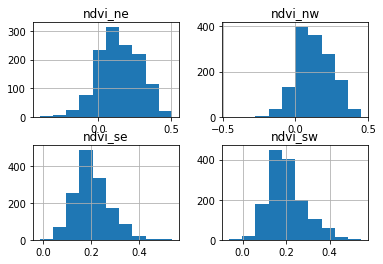

In [255]:
df[["ndvi_se","ndvi_sw","ndvi_ne","ndvi_nw"]].hist()

We could drop ndvi_ne as it is highly correlated with ndvi_nw, however currently we will try imputing with the mean of the other 3 ndvi variables. The 52 cases where ndvi_nw is missing, we will replace with the mean of ndvi_se and ndvi_sw. Where ndvi_se and ndvi_s are missing, we will impute with the mean. 

In [256]:
df.ndvi_se.fillna(df.ndvi_se.mean(),inplace=True)
df.ndvi_sw.fillna(df.ndvi_sw.mean(),inplace=True)
df.ndvi_nw.fillna((df.ndvi_sw + df.ndvi_se)/2,inplace=True)
df.ndvi_ne.fillna((df.ndvi_sw + df.ndvi_se + df.ndvi_nw)/3,inplace=True)

We will impute other rows with missing values with the mean of the respective column.

In [258]:
df.fillna(df.mean(),inplace=True)

We will eventually going to drop year from the subesquent analysis, due to potential data leakage, but we will engineer some features using it later on.  

In [259]:
#df.drop("year", axis=1,inplace=True)
#df.columns

## Categorial Features

In [260]:
cat_features = df.loc[:,(df.dtypes=='object')]
cat_features.columns

Index(['city', 'week_start_date'], dtype='object')

For now we will drop week_start_date. The day of the month likely has no bearing on dengue cases, week is already represented in its own feature/column, and year is being dropped due to leakage. 

In [261]:
df.drop('week_start_date', axis=1,inplace=True)
#df.columns

Lets look at the city attribute.

In [262]:
df.city.unique()

array(['sj', 'iq'], dtype=object)

Only two cities. Will do categorical encoding (though one-hot could also be used)

In [263]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["sj","iq"])
#le.classes_
df.city=le.transform(df.city)
df.head()


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [264]:
df.dtypes

city                                       int32
year                                       int64
weekofyear                                 int64
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c  

## Feature Associations

So, we no longer have any categorical variable, and no missing values. No lets take a look at correlation between variables.

In [265]:
import seaborn as sn

def plot_corr_matrix(df, subset=[], details="All Features"):

    if len(subset)>0:
        df = df[subset]
        
    corr = df.corr()
    #cmap = sn.diverging_palette(255, 133, l=60, n=7, center="dark")
    
    # The values number here ar just for "nice" scaling
    xx=(df.shape[1]/3,(df.shape[1]/3)*.85 )
    fig=plt.figure(figsize=xx)
    ax = sn.heatmap(corr,cmap='RdBu_r',vmin=-1,vmax=1)

    ax.set_title("Correlation for "+details)

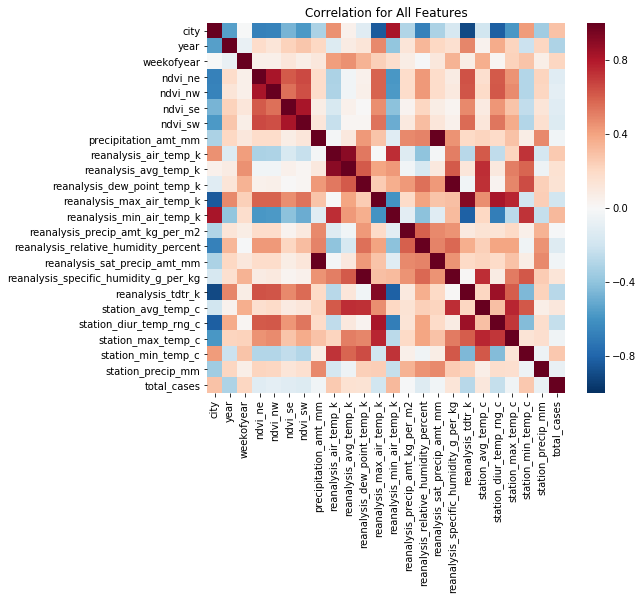

In [266]:
# Let's start by looking at all features; target variable is in the last row/column
plot_corr_matrix(df=df, subset=[], details="All Features") 

The bottom row and right-most column on the above correlation matrix show how each feature correlates with total cases. We observe many features that are weekly-to-moderately correlated with total_case(0.2-0.4), but none that are ***strongly*** correlated.

Text(0.5,1,'Feature Correlation (with Target)')

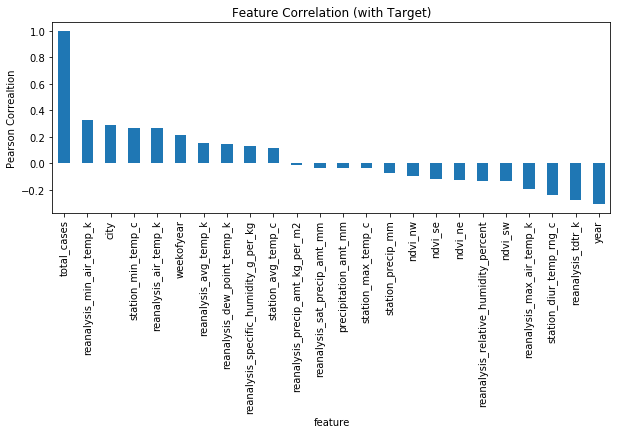

In [267]:
plt.figure(figsize=(10,3.5))
#%matplotlib inline
df.corr().iloc[-1].sort_values(ascending=False).plot(kind="bar")
#plt.show()
plt.xlabel('feature')
plt.ylabel('Pearson Correaltion')
plt.title('Feature Correlation (with Target)')

In [324]:
_=abs(df.corr()).iloc[-1].sort_values(ascending=False)
high_corr_feat = list(_.index[0:10])
print(high_corr_feat)

['total_cases', 'reanalysis_min_air_temp_k', 'year', 'city', 'reanalysis_tdtr_k', 'station_min_temp_c', 'reanalysis_air_temp_k', 'station_diur_temp_rng_c', 'weekofyear', 'reanalysis_max_air_temp_k']


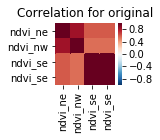

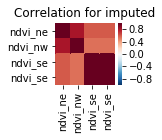

In [268]:
# Check the correlation matrices for the ndvi features, before and after imputation
plot_corr_matrix(df=df_o, subset=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_se'], details="original") 
plot_corr_matrix(df=df, subset=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_se'], details="imputed") 

No lets look how the data are distributed.

In [300]:
print(df.columns[7:18])

Index(['precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k'],
      dtype='object')


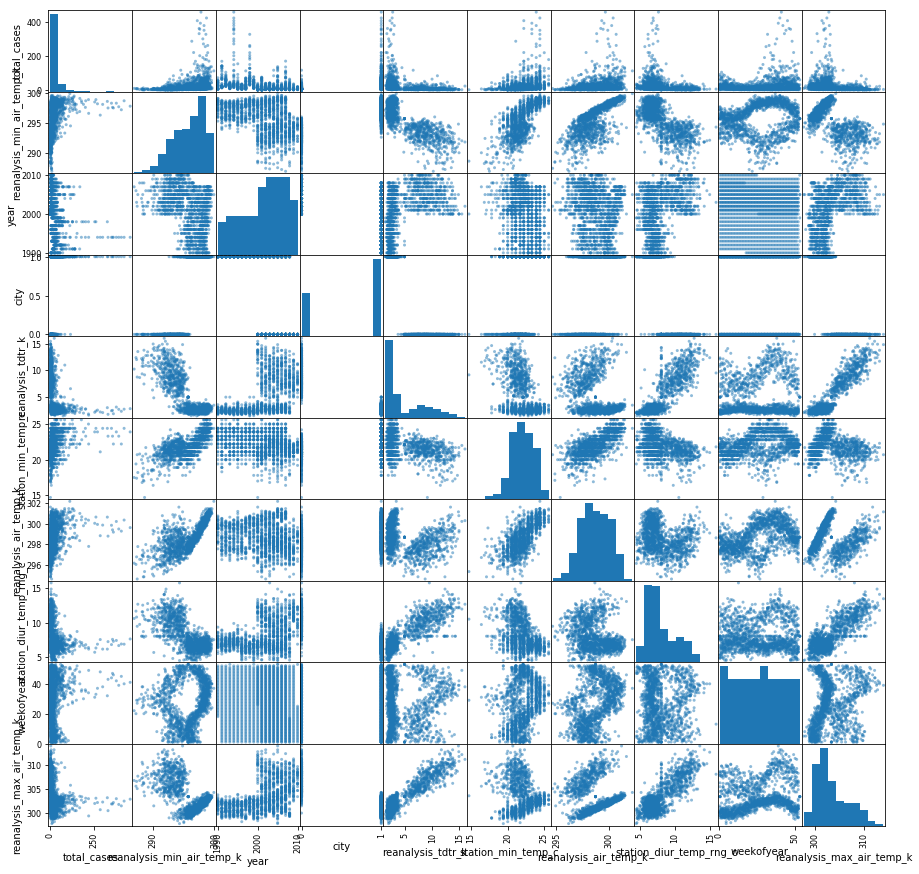

In [327]:
_=pd.plotting.scatter_matrix(df[high_corr_feat], figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E98268AEB8>,
      dtype=object)

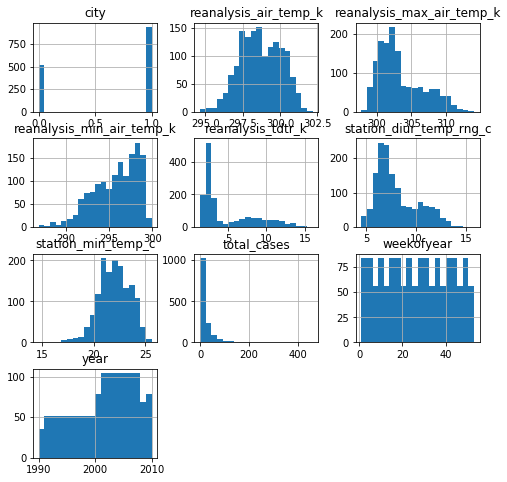

In [329]:
df[high_corr_feat].hist(figsize=(8,8), bins=20)



### Prepare the Data (split into x and y)

In [269]:
x = df.copy()
x.drop("total_cases", axis=1, inplace=True)
y = df.total_cases

In [270]:
#numberical featuers (all feature should now be numerical)
num_features = x.loc[:,(df.dtypes=='int64')|(df.dtypes=='float64')|(df.dtypes=='int32')]
num_features.columns
num_features.dtypes

city                                       int32
year                                       int64
weekofyear                                 int64
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c  

## Baseline Linear Regression Model

Now that we've done some basic data exploration and cleaning, let's do a preliminarly linear regression before any feature engineering. This will serve as starting point. We will just take numerical features--we will explore categorical encoding a bit later on. 

First let's funcationalize our linear regression model.


In [257]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [271]:
def lin_reg(x,y, features=[],do_scale=True, show_cm=False,normTF=True):
    
    if len(features)>0:
        #print(len(features)>0)
        x=x[features]
    
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    model = LinearRegression()
    if do_scale:
        regressor = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        regressor = Pipeline(steps = [('model',model)])
        
    regressor.fit(x_train,y_train)
    y_predict = regressor.predict(x_val)
    
    scores = cross_val_score(regressor, x, y, cv=5, scoring='r2')
    print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # Display some random validation vs predicted y pairs
    rand_samp = list(np.random.choice(range(len(y_val)),10,replace=False))
    y_top = np.array(y_val.iloc[rand_samp])
    # Rounding the predicted values for display purposes
    yp_top = np.array(y_predict[rand_samp]).round()
    
    Y = np.array([y_top,yp_top]).T
    print(Y)

In [272]:
from sklearn.tree import DecisionTreeRegressor

def dtree_reg(x,y, features=[],do_scale=True, show_cm=False,normTF=True):
    
    if len(features)>0:
        #print(len(features)>0)
        x=x[features]
    
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    model = DecisionTreeRegressor(random_state=3)
    if do_scale:
        regressor = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        regressor = Pipeline(steps = [('model',model)])
        
    regressor.fit(x_train,y_train)
    y_predict = regressor.predict(x_val)
    
    scores = cross_val_score(regressor, x, y, cv=5, scoring='r2')
    print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # Display some random validation vs predicted y pairs
    rand_samp = list(np.random.choice(range(len(y_val)),10,replace=False))
    y_top = np.array(y_val.iloc[rand_samp])
    # Rounding the predicted values for display purposes
    yp_top = np.array(y_predict[rand_samp]).round()
    
    Y = np.array([y_top,yp_top]).T
    print(Y)

In [273]:
from sklearn.ensemble import RandomForestRegressor

def randfor_reg(x,y, features=[],do_scale=True, show_cm=False,normTF=True):
    
    if len(features)>0:
        #print(len(features)>0)
        x=x[features]
    
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    model = RandomForestRegressor(random_state=3)
    if do_scale:
        regressor = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        regressor = Pipeline(steps = [('model',model)])
        
    regressor.fit(x_train,y_train)
    y_predict = regressor.predict(x_val)
    
    scores = cross_val_score(regressor, x, y, cv=5, scoring='r2')
    print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # Display some random validation vs predicted y pairs
    rand_samp = list(np.random.choice(range(len(y_val)),10,replace=False))
    y_top = np.array(y_val.iloc[rand_samp])
    # Rounding the predicted values for display purposes
    yp_top = np.array(y_predict[rand_samp]).round()
    
    Y = np.array([y_top,yp_top]).T
    print(Y)

In [274]:
# Baseline Linear regression, no bell/whistles, to get a starting point
# all numerical features
lin_reg(x,y)

R2: -0.48 (+/- 1.27)
[[ 8.  4.]
 [ 0.  3.]
 [ 3. 11.]
 [ 4. 11.]
 [37. 35.]
 [92. 35.]
 [ 5.  5.]
 [ 4. -6.]
 [19. 18.]
 [23. 21.]]


In [275]:
# Baseline scores for decision tree
dtree_reg(x,y)

R2: -0.83 (+/- 1.46)
[[129. 116.]
 [  7.   3.]
 [  0.   9.]
 [  7.   3.]
 [ 26.  15.]
 [ 10.   7.]
 [  4.  14.]
 [  5.   9.]
 [  4.   5.]
 [ 13.  17.]]


In [276]:
# Baseline scores for decision tree
randfor_reg(x,y)

C:\Users\ewell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: -0.42 (+/- 1.29)
[[ 7. 10.]
 [ 4.  3.]
 [ 1.  4.]
 [13. 18.]
 [ 8.  4.]
 [ 6.  8.]
 [65. 30.]
 [22. 13.]
 [ 0.  2.]
 [ 0.  1.]]


So, we're clearly starting from a place of poor prediction. Plenty of room for improvement!

The plan going forward is to:
* Perform categorical encoding for our categorical feature
* Engineer some features
* Explore some other regression models and choose 2-3 to fine-tune
* Optimize our chosen models using regularization and gridsearc

## Feature Engineering

The first feature to engineer is an obvious one: number of case for the same city in the previous year. While we are at it, we could do it for a range of previous years. Lets limit it at 3.  The year range for this data is 1990-2010. So if we want to do a feature for each of the 3 previous year, problems arrise for 1990, 1991,and 1992. 1991 and 92 both have data avaible for **one** year previous, but 92 does not have data for **three** years previous, and and 91 does not for **two or three** years prior. So those years will have to be dealt with differently.  

In [277]:
#df.sample(5)
#df.set_index(['city','year','weekofyear'],inplace=True)
#df.sample(5)


In [278]:
years = (list(range(1993,2011)))
df_sub=df.loc[(df.year<=2010)&(df.year>=1993)]
print(years)
#df_sub=df.loc[df.year.isin(years)]
df_sub.tail()

[1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1451,0,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,0,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,0,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,0,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1
1455,0,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,299.835714,...,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4,4


In [279]:
for i in range(len(df_sub)):
    case_one_prior= df.loc[(df.city == df_sub.iloc[i].city)&(df.weekofyear == df_sub.iloc[i].weekofyear)&
                           (df.year == (df_sub.iloc[i].year-1))].total_cases
    

In [280]:
(df.city == df_sub.iloc[i].city)&(df.weekofyear == df_sub.iloc[i].weekofyear)&(df.year == (df_sub.iloc[i].year-1))

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1426    False
1427    False
1428    False
1429    False
1430    False
1431    False
1432    False
1433    False
1434    False
1435    False
1436    False
1437    False
1438    False
1439    False
1440    False
1441    False
1442    False
1443    False
1444    False
1445    False
1446    False
1447    False
1448    False
1449    False
1450    False
1451    False
1452    False
1453    False
1454    False
1455    False
Length: 1456, dtype: bool

In [281]:
df_sub.total_cases

139     30
140     32
141     28
142     33
143     33
144     35
145     22
146     13
147     13
148     21
149     17
150     11
151      8
152      8
153      6
154      6
155      7
156     12
157     17
158     10
159     10
160     18
161     19
162     12
163     22
164     12
165     21
166     18
167     16
168     16
        ..
1426     4
1427     4
1428     1
1429     0
1430     0
1431    10
1432     9
1433    17
1434    16
1435    11
1436    12
1437    19
1438    15
1439    12
1440    12
1441    16
1442     9
1443     4
1444     9
1445     6
1446     8
1447     4
1448     2
1449     7
1450     6
1451     5
1452     8
1453     1
1454     1
1455     4
Name: total_cases, Length: 1317, dtype: int64

In [282]:
df.index

RangeIndex(start=0, stop=1456, step=1)

## Model Selection

We will contiue to explore the linear regression model (lasso/ridge/elasticnet regularization explored later), but well will also investicate SVMs, Naive Bayes, Decision Trees. Ensemble methods will be exlored later on.  